In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from ipywidgets import interact
from matplotlib.colors import LinearSegmentedColormap
from polars import col
from scipy.interpolate import interp1d
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.labels import add_labels
from src.features.resampling import (
    add_normalized_timestamp,
    interpolate_and_fill_nulls,
    resample_at_10_hz_equidistant,
)
from src.features.scaling import scale_min_max, scale_robust_standard, scale_standard
from src.log_config import configure_logging
from src.models.architectures import LongShortTermMemory, MultiLayerPerceptron
from src.models.data_loader import create_dataloaders, transform_sample_df_to_arrays
from src.models.data_preparation import prepare_data
from src.models.main import RANDOM_SEED
from src.models.sample_creation import create_samples, make_sample_set_balanced
from src.models.scalers import StandardScaler3D, scale_dataset
from src.models.utils import get_device, get_input_shape, load_model, save_model
from src.plots.utils import prepare_multiline_hvplot

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

device = get_device()

16:25:55 | INFO    | utils | Using device: mps


In [3]:
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic_heartrate_pupil_mean/model/PatchTST_20250429-141311.pt"
)


16:25:56 | INFO    | utils | Using device: mps
16:25:56 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77%
16:25:56 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_phasic', 'eda_tonic', 'heartrate', 'pupil_mean']


In [ ]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

In [ ]:
feature_list = [
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "heartrate",
]

sample_duration_ms = 5000

# Get particpant IDs from test set
test_ids = prepare_data(
    df,
    feature_list,
    sample_duration_ms,
    RANDOM_SEED,
    return_only_groups_for_test=True,
)
test_ids

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
317,1,30,26400.4822,0.0,0.0,0.377668,0.377164,0.000504,1405.794976,-0.998848,88.586043,3.875653,3.647632,3.375692,3.712002,3.543847,3.562173,0.00003,0.0,0.00168,0.0,0.00001,0.0,952,6,0,0,1581,1581,949,0,0
317,1,30,26500.4822,0.000212,0.0,0.378314,0.377202,0.001111,1409.417861,20.444398,84.260746,3.788312,3.562748,3.37841,3.718432,3.548421,3.569993,0.000029,0.0,0.001573,0.0,0.00001,100.0,952,6,0,0,1581,1581,949,0,0
317,1,30,26600.4822,0.000937,0.490254,0.378135,0.377233,0.000902,1388.979664,58.495517,80.275208,3.731524,3.490336,3.387373,3.738698,3.563035,3.580041,0.000023,0.0,0.00088,0.0,0.00001,200.0,952,6,0,0,1581,1581,949,0,0
317,1,30,26700.4822,0.002264,0.911092,0.378233,0.377263,0.00097,1374.247096,3.108515,76.664802,3.717975,3.434111,3.398264,3.751255,3.574759,3.590938,0.000027,0.0,0.001365,0.0,0.00001,300.0,952,6,0,0,1581,1581,949,0,0
317,1,30,26800.4822,0.004191,1.0,0.378224,0.377288,0.000936,1365.497625,-9.049997,74.103405,3.735377,3.394941,3.410055,3.759203,3.584629,3.603124,0.000016,0.0,0.001948,0.0,0.00001,400.0,952,6,0,0,1581,1581,949,0,0
317,1,30,26900.4822,0.006696,1.0,0.37814,0.377326,0.000814,1365.363052,4.257401,71.610745,3.757781,3.3728,3.422707,3.770144,3.596425,3.61639,0.00001,0.0,0.001538,0.0,0.00001,500.0,952,6,0,0,1581,1581,949,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
328,12,30,2.7770e6,0.042334,0.0,2.553515,2.55581,-0.002694,1408.736208,40.322606,81.11342,3.729493,3.51849,3.435112,3.582489,3.508801,3.368213,0.00001,0.0,0.013056,0.0,0.00001,179500.0,743,1,1640,984,0,0,0,0,0
328,12,30,2.7771e6,0.041897,0.0,2.55349,2.555808,-0.002852,1393.752574,23.615361,83.121999,3.719854,3.524432,3.453553,3.591344,3.522449,3.365452,0.000044,0.000009,0.066004,0.0,0.000061,179600.0,743,1,1640,984,0,0,0,0,0


In [197]:
intervals = {
    # "decreases": "decreasing_intervals",
    "decreases": "major_decreasing_intervals",
    "increases": "strictly_increasing_intervals_without_plateaus",
    # "plateaus": "plateau_intervals",
}
label_mapping = {
    "decreases": 0,
    "increases": 1,
    # "plateaus": 1,
}
sample_duration_ms = 5_000

samples = create_samples(df, intervals, sample_duration_ms, label_mapping)
samples = make_sample_set_balanced(
    samples
)  # TODO: improve balance function, maybe use f1 or mcc as metric instead of accuracy
samples = samples.select(
    "sample_id",
    "participant_id",
    "timestamp",
    "temperature",
    "eda_raw",
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "pupil_mean_tonic",
    "label",
)
print(samples["label"].value_counts())
samples


TypeError: create_samples() takes from 1 to 3 positional arguments but 4 were given

In [ ]:
X, y, groups = transform_sample_df_to_arrays(
    samples,
    feature_columns=[
        # "temperature",  # only for visualization
        # "rating"
        "eda_tonic",
        "eda_phasic",
        "pupil_mean",
    ],
)
print(f"{X.shape=}, {y.shape=}, {groups.shape=}")


@interact(trial=(0, X.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X[trial, :, i])
    # plt.ylim(0, 1.05)

X.shape=(2826, 51, 3), y.shape=(2826, 2), groups.shape=(2826,)


interactive(children=(IntSlider(value=1412, description='trial', max=2825), Output()), _dom_classes=('widget-i…

In [198]:
# Create a single train-test split while respecting group structure in the data
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# might not be exactly 50% due to group structure
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
assert set(groups[train_idx]).isdisjoint(set(groups[test_idx])), "Overlap in groups"
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


X_train, X_test = scale_dataset(X_train, X_test)


@interact(trial=(0, X_train.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X_train[trial, :, i])
    # plt.ylim(0, 1.05)

NameError: name 'X' is not defined

In [199]:
batch_size = 64

train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
    is_test=True,
)

NameError: name 'X_train' is not defined

In [200]:
next(iter(train_loader))[0].numpy().shape

NameError: name 'train_loader' is not defined

In [6]:
model = load_model("models/PatchTST_20250312-215612.pt")

00:10:27 | INFO    | utils | Using device: mps
00:10:27 | INFO    | utils | Loaded PatchTST model with test accuracy 0.78%
00:10:27 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_tonic', 'eda_phasic', 'pupil_mean', 'heartrate']


In [145]:
np.unique(groups[idx_test])

array([ 7, 11, 17, 24, 30, 33, 36, 37, 48], dtype=uint8)

In [13]:
X_test.shape

(606, 50, 4)

Accuracy: 0.752


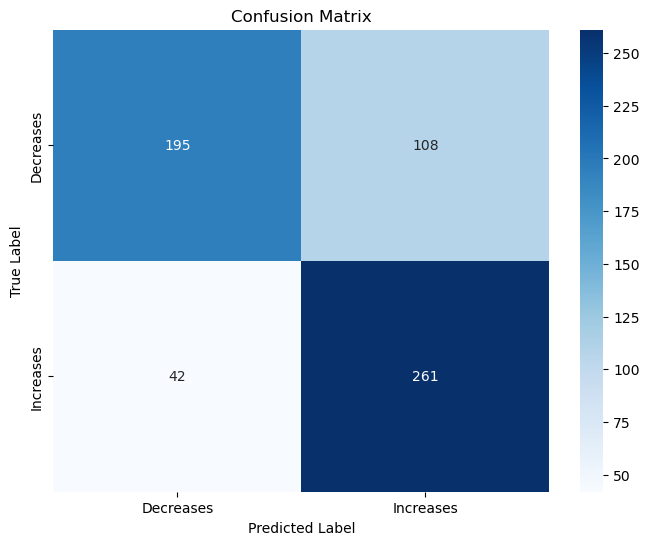

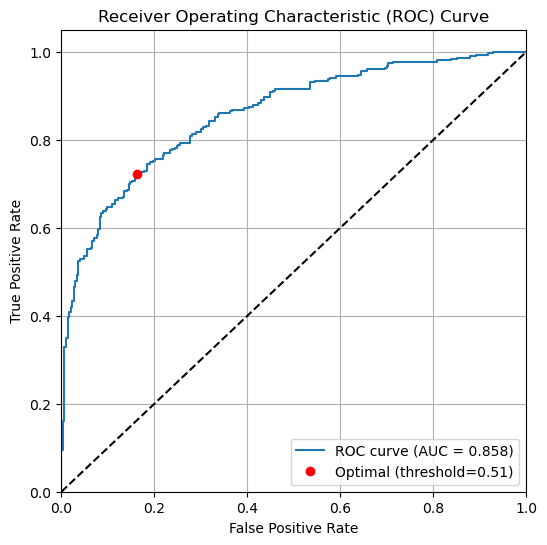

In [ ]:
def get_confusion_matrix(
    model: nn.Module,
    test_loader: DataLoader,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Calculate confusion matrix for binary classification.
    Returns a 2x2 numpy array where:
    [0,0] = TN, [0,1] = FP
    [1,0] = FN, [1,1] = TP
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)

            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=1)
            # Get predictions based on threshold of positive class probability
            y_pred_batch = (probs[:, 1] >= threshold).cpu().numpy()

            # Convert labels to numpy array
            if len(y_batch.shape) > 1:  # one-hot encoded
                y_batch = y_batch[:, 1].cpu().numpy()
            else:
                y_batch = y_batch.cpu().numpy()

            all_preds.append(y_pred_batch)
            all_labels.append(y_batch)

    # Concatenate batches
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")

    return confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Decreases", "Increases"],
        yticklabels=["Decreases", "Increases"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_roc_curve(
    model: nn.Module,
    test_loader: DataLoader,
) -> None:
    """
    Plot ROC curve and calculate AUC score for binary classification.
    """
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)

            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=1)
            # Get probability of positive class (class 1)
            y_scores_batch = probs[:, 1].cpu().numpy()

            # Convert labels to numpy array
            if len(y_batch.shape) > 1:  # one-hot encoded
                y_batch = y_batch[:, 1].cpu().numpy()
            else:
                y_batch = y_batch.cpu().numpy()

            all_labels.append(y_batch)
            all_scores.append(y_scores_batch)

    # Concatenate batches
    y_true = np.concatenate(all_labels)
    y_scores = np.concatenate(all_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")  # diagonal line

    # Add marker for optimal threshold
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        "ro",
        label=f"Optimal (threshold={optimal_threshold:.2f})",
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.3)
plot_confusion_matrix(conf_matrix)
plot_roc_curve(model, test_loader)

Accuracy: 0.776


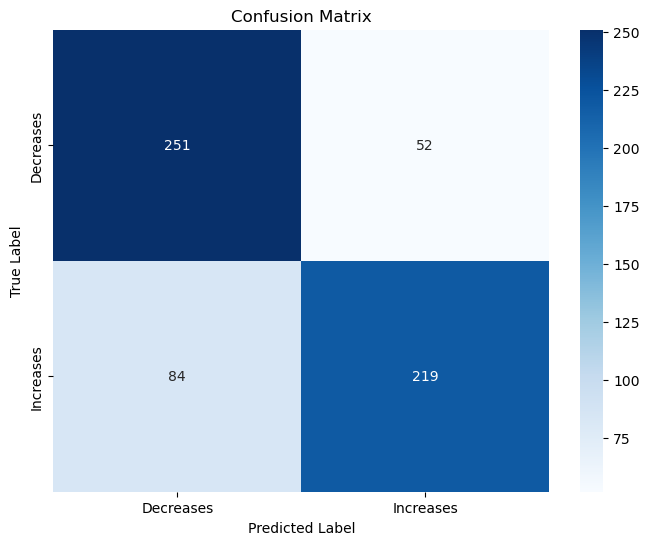

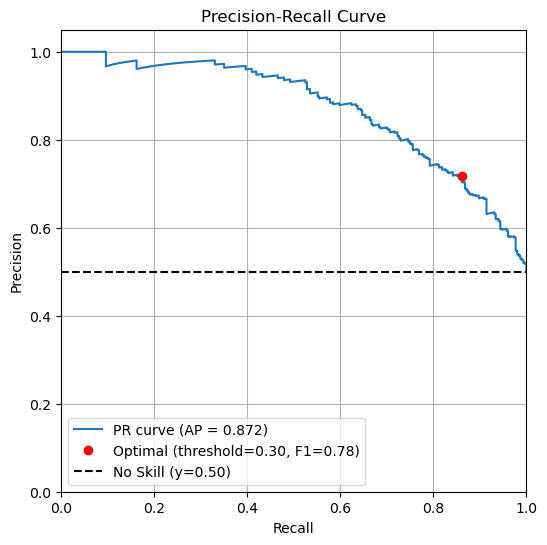

Average Precision: 0.8721
Optimal threshold (from PR curve): 0.3047


In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve


def plot_pr_curve(
    model: nn.Module,
    test_loader: DataLoader,
) -> None:
    """
    Plot Precision-Recall curve and calculate Average Precision score for binary classification.
    """
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)

            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=1)
            # Get probability of positive class (class 1)
            y_scores_batch = probs[:, 1].cpu().numpy()

            # Convert labels to numpy array
            if len(y_batch.shape) > 1:  # one-hot encoded
                y_batch = y_batch[:, 1].cpu().numpy()
            else:
                y_batch = y_batch.cpu().numpy()

            all_labels.append(y_batch)
            all_scores.append(y_scores_batch)

    # Concatenate batches
    y_true = np.concatenate(all_labels)
    y_scores = np.concatenate(all_scores)

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    # Calculate F1 score at each threshold to find optimal threshold
    f1_scores = (
        2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    )
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Plot precision-recall curve
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")

    # Add marker for optimal threshold
    plt.plot(
        recall[optimal_idx],
        precision[optimal_idx],
        "ro",
        label=f"Optimal (threshold={optimal_threshold:.2f}, F1={f1_scores[optimal_idx]:.2f})",
    )

    # Calculate no-skill line (ratio of positive samples)
    no_skill = sum(y_true) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], "k--", label=f"No Skill (y={no_skill:.2f})")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return avg_precision, optimal_threshold


# First use your fixed confusion matrix function
conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.5)
plot_confusion_matrix(conf_matrix)

# Plot both ROC and PR curves
ap_score, optimal_pr_threshold = plot_pr_curve(model, test_loader)

print(f"Average Precision: {ap_score:.4f}")
print(f"Optimal threshold (from PR curve): {optimal_pr_threshold:.4f}")

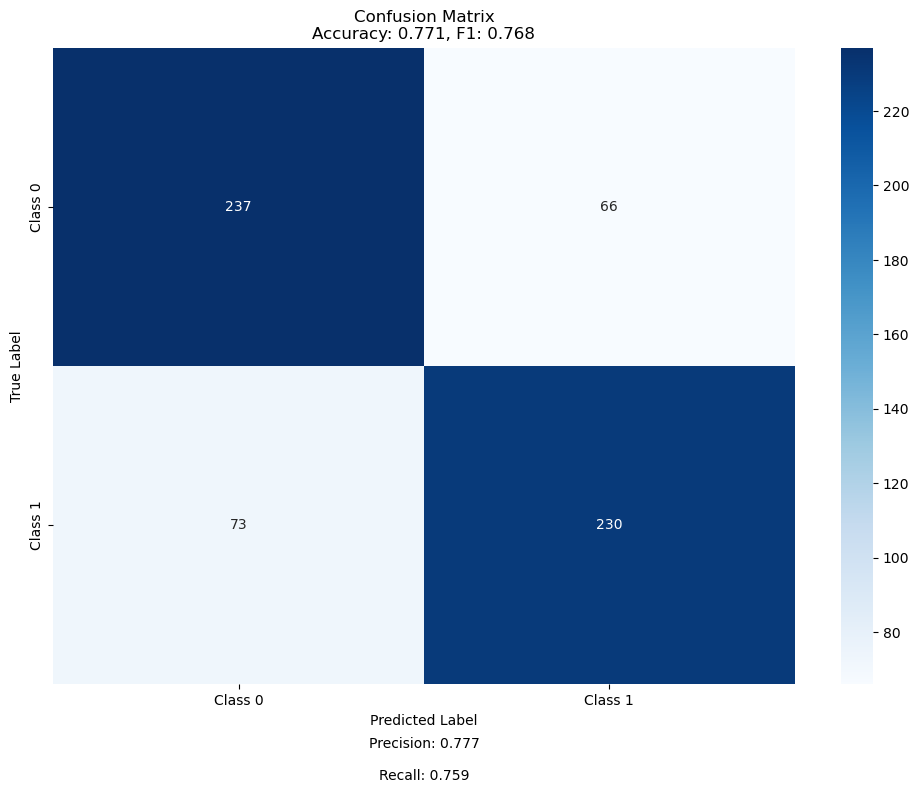

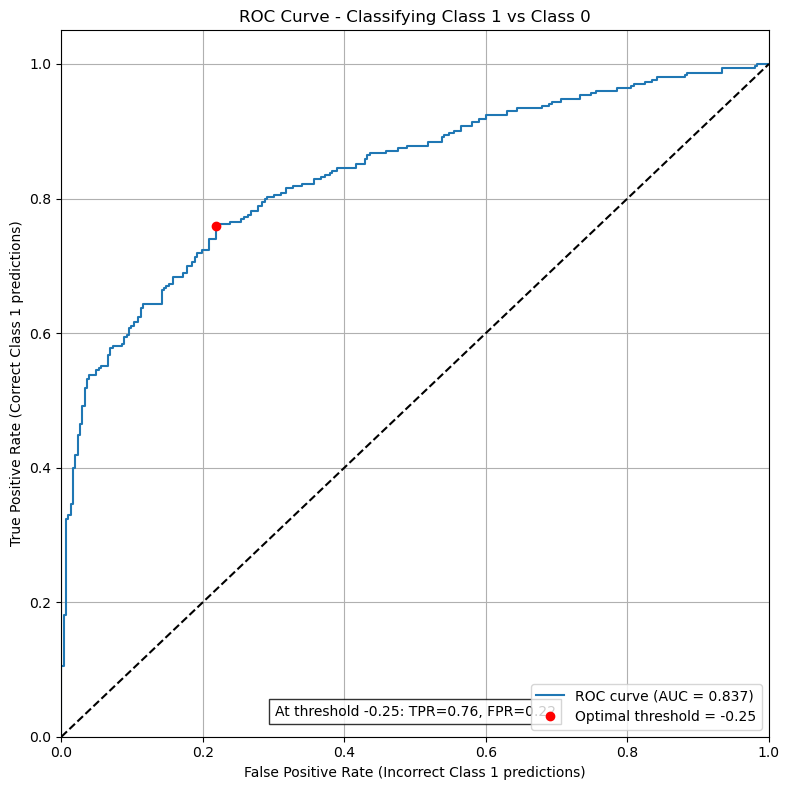

In [ ]:
def plot_confusion_matrix(conf_matrix: np.ndarray, class_names=None) -> None:
    """
    Plot confusion matrix with customizable class names.

    Args:
        conf_matrix: 2x2 confusion matrix (TN, FP, FN, TP)
        class_names: List of class names [negative_class_name, positive_class_name]
    """
    if class_names is None:
        class_names = ["Class 0", "Class 1"]

    # Calculate metrics to display
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.3f}, F1: {f1:.3f}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # Add text annotations for precision and recall
    plt.text(
        0.5,
        -0.1,
        f"Precision: {precision:.3f}",
        ha="center",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.5, -0.15, f"Recall: {recall:.3f}", ha="center", transform=plt.gca().transAxes
    )

    plt.tight_layout()
    plt.show()


def plot_roc_curve(
    model: nn.Module,
    test_loader: DataLoader,
    class_names=None,
) -> None:
    """
    Plot ROC curve with customizable class names.

    Args:
        model: PyTorch model
        test_loader: DataLoader for test set
        class_names: List of class names [negative_class_name, positive_class_name]
    """
    if class_names is None:
        class_names = ["Class 0", "Class 1"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)

            # For models that output two probabilities (one for each class)
            if outputs.shape[1] == 2:
                # Use the probability of the positive class
                y_scores_batch = outputs[:, 1].cpu().numpy()
                # For one-hot encoded targets, get the true class
                if y_batch.shape[1] == 2:
                    y_batch = y_batch[:, 1].cpu().numpy()
                else:
                    y_batch = y_batch.cpu().numpy()
            else:
                # For models with a single output
                y_scores_batch = torch.sigmoid(outputs).squeeze().cpu().numpy()
                y_batch = y_batch.cpu().numpy()

            all_labels.append(y_batch)
            all_scores.append(y_scores_batch)

    # Concatenate batches
    y_true = np.concatenate(all_labels)
    y_scores = np.concatenate(all_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")  # diagonal line

    # Add marker for optimal threshold
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        "ro",
        label=f"Optimal threshold = {optimal_threshold:.2f}",
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(f"False Positive Rate (Incorrect {class_names[1]} predictions)")
    plt.ylabel(f"True Positive Rate (Correct {class_names[1]} predictions)")
    plt.title(f"ROC Curve - Classifying {class_names[1]} vs {class_names[0]}")
    plt.legend(loc="lower right")
    plt.grid(True)

    # Add text for threshold explanation
    plt.text(
        0.5,
        0.03,
        f"At threshold {optimal_threshold:.2f}: TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f}",
        ha="center",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()


conf_matrix = get_confusion_matrix(model, test_loader, threshold=-0.25)
plot_confusion_matrix(conf_matrix)
plot_roc_curve(model, test_loader)